In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import display
from qutip import (about, basis, coherent, coherent_dm, displace, fock, ket2dm,
                   plot_wigner, squeeze, thermal_dm, wigner_cmap, wigner)

import scipy.ndimage
import os
from tqdm import tqdm

def rotate_and_crop(array, angle, xvec, yvec):
    rotated_array = scipy.ndimage.rotate(array, -angle, reshape=False)
    rows, cols = rotated_array.shape
    center_row, center_col = rows // 2, cols // 2
    target_rows, target_cols = len(yvec), len(xvec)
    start_row = center_row - target_rows // 2
    end_row = start_row + target_rows
    start_col = center_col - target_cols // 2
    end_col = start_col + target_cols
    return rotated_array[start_row:end_row, start_col:end_col]

def plot_wigner_marginals(W, xvec, yvec, marginal_max, resolution=200, angle=0, plot_marginals=True):
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']

    if not plot_marginals:
        fig, ax = plt.subplots(figsize=(20, 20))
        norm = mpl.colors.Normalize(-wlim, wlim)
        ax.contourf(xvec, yvec, W, resolution // 3, norm=norm, cmap=cmap)
        return fig, ax
    
    fig = plt.figure()
    n, m = 5, 1
    fig, axes = plt.subplot_mosaic(
        [ ["top"] * n + ["3d"] * m ] * m + [ ["mid"] * n + ["right"] * m] * n,
    figsize=(20, 20),
    layout="constrained",
    width_ratios=[1.05] * (n+m))

    ax = axes["mid"]
    norm = mpl.colors.Normalize(-wlim, wlim)
    ax.contourf(xvec, yvec, W, resolution // 3, norm=norm, cmap=cmap)
    

    ax = axes["top"]
    x_marginal = np.sum(W, axis=0)
    y_marginal = np.sum(W, axis=1)
    ax.fill_between(xvec, x_marginal, 0, color='#938fbc', alpha=0.5)
    ax.plot(xvec, x_marginal, color='#4a5a90')
    ax.set_xlim(min(xvec), max(xvec))
    ax.set_ylim(0, marginal_max * 1.05)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes["right"]
    ax.fill_betweenx(yvec, np.sum(W, axis=1), 0, color='#938fbc', alpha=0.5)
    ax.plot(y_marginal, yvec, color='#4a5a90')
    ax.set_xlim(0, marginal_max * 1.05)
    ax.set_ylim(min(yvec), max(yvec))
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes["3d"]
    ax.axis('off')

    return fig, axes

def plot_wigner_with_marginals(psi, **kwargs):
    
    radius = kwargs.get('radius', 5) 
    resolution = kwargs.get('resolution', 500)
    angles = kwargs.get('angles', np.linspace(0, 2*np.pi, 100))
    dir_path = kwargs.get('dir_path', './output')
    
    xvec_upscaled = np.linspace(-radius*1.5, radius*1.5, int(resolution*1.5))
    yvec_upscaled = np.linspace(-radius*1.5, radius*1.5, int(resolution*1.5))
    xvec = np.linspace(-radius, radius, int(resolution))
    yvec = np.linspace(-radius, radius, int(resolution))

    W_upscaled = wigner(psi, xvec_upscaled, yvec_upscaled)
    marginal_max = max(max(np.sum(W_upscaled, axis=0)), max(np.sum(W_upscaled, axis=1)))
    print(f"outputting to {dir_path}")
    for N, angle in tqdm(enumerate(angles)):
        W = rotate_and_crop(W_upscaled, angle, xvec, yvec)
        fig = plot_wigner_marginals(W, xvec, yvec, marginal_max=marginal_max, resolution=resolution, angle=angle)

        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        fig.savefig(f"{dir_path}/{N:03d}.png",bbox_inches='tight')
        plt.close(fig)


<Figure size 640x480 with 0 Axes>

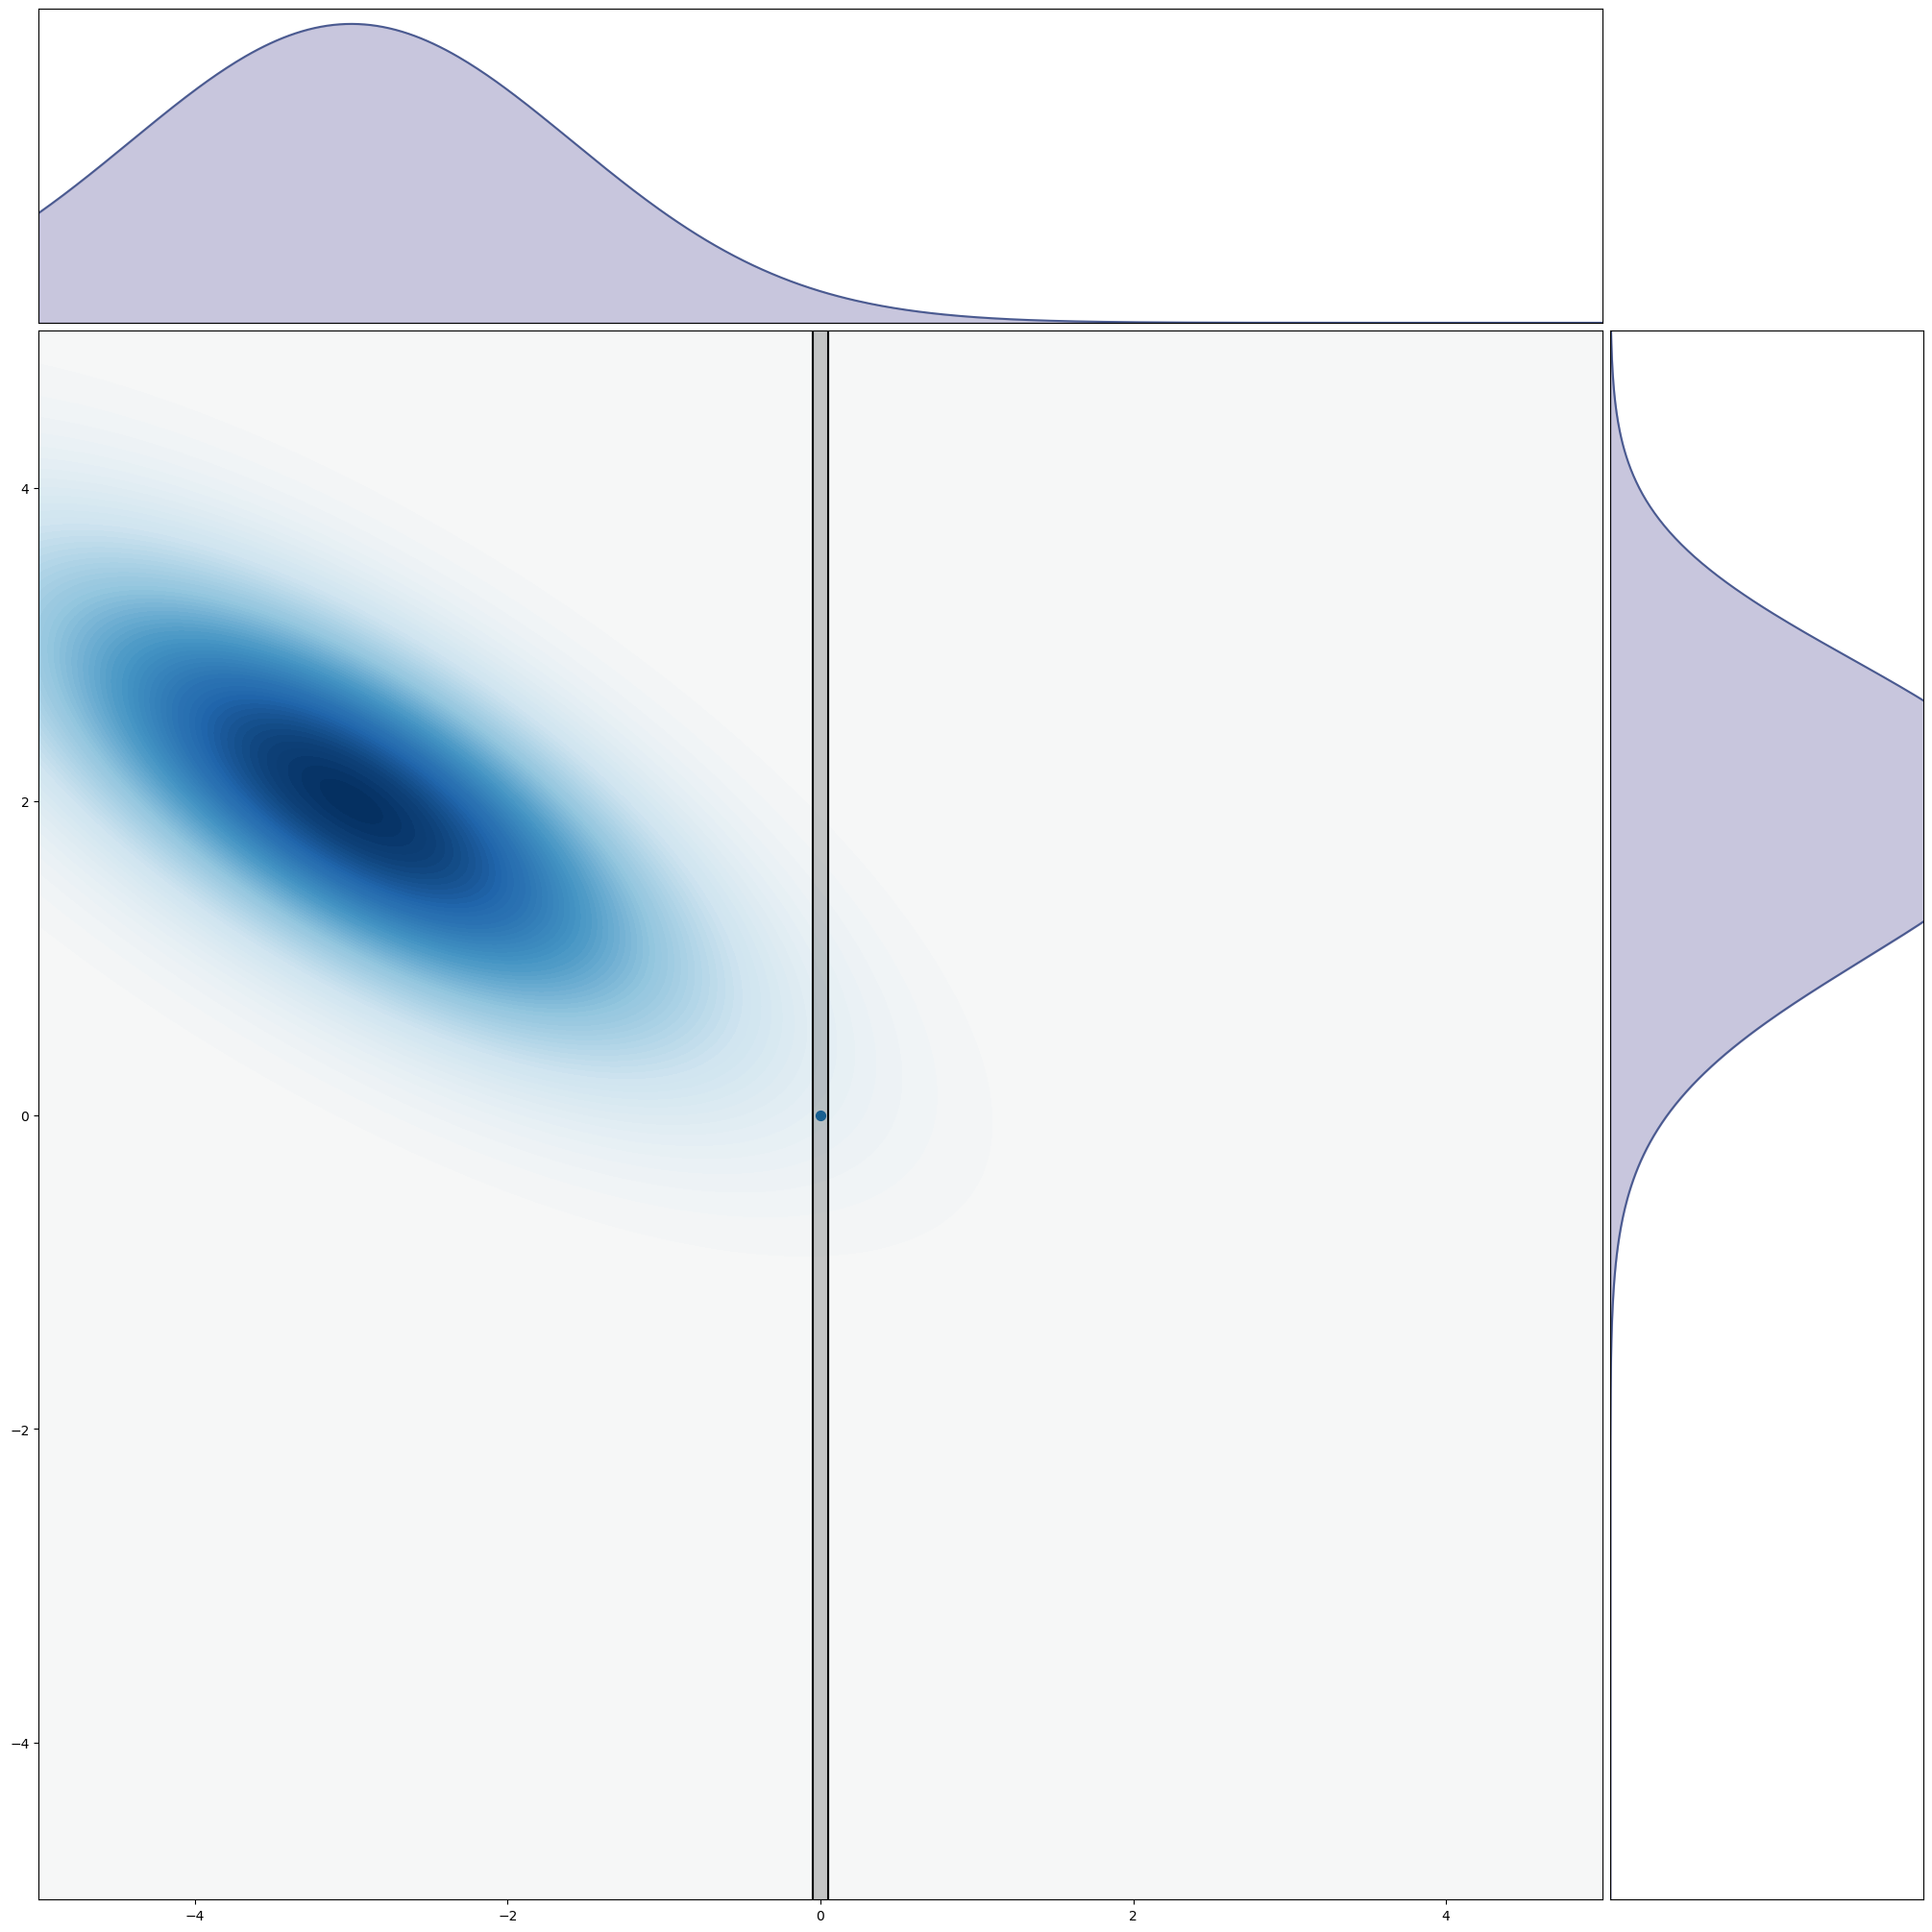

<Figure size 640x480 with 0 Axes>

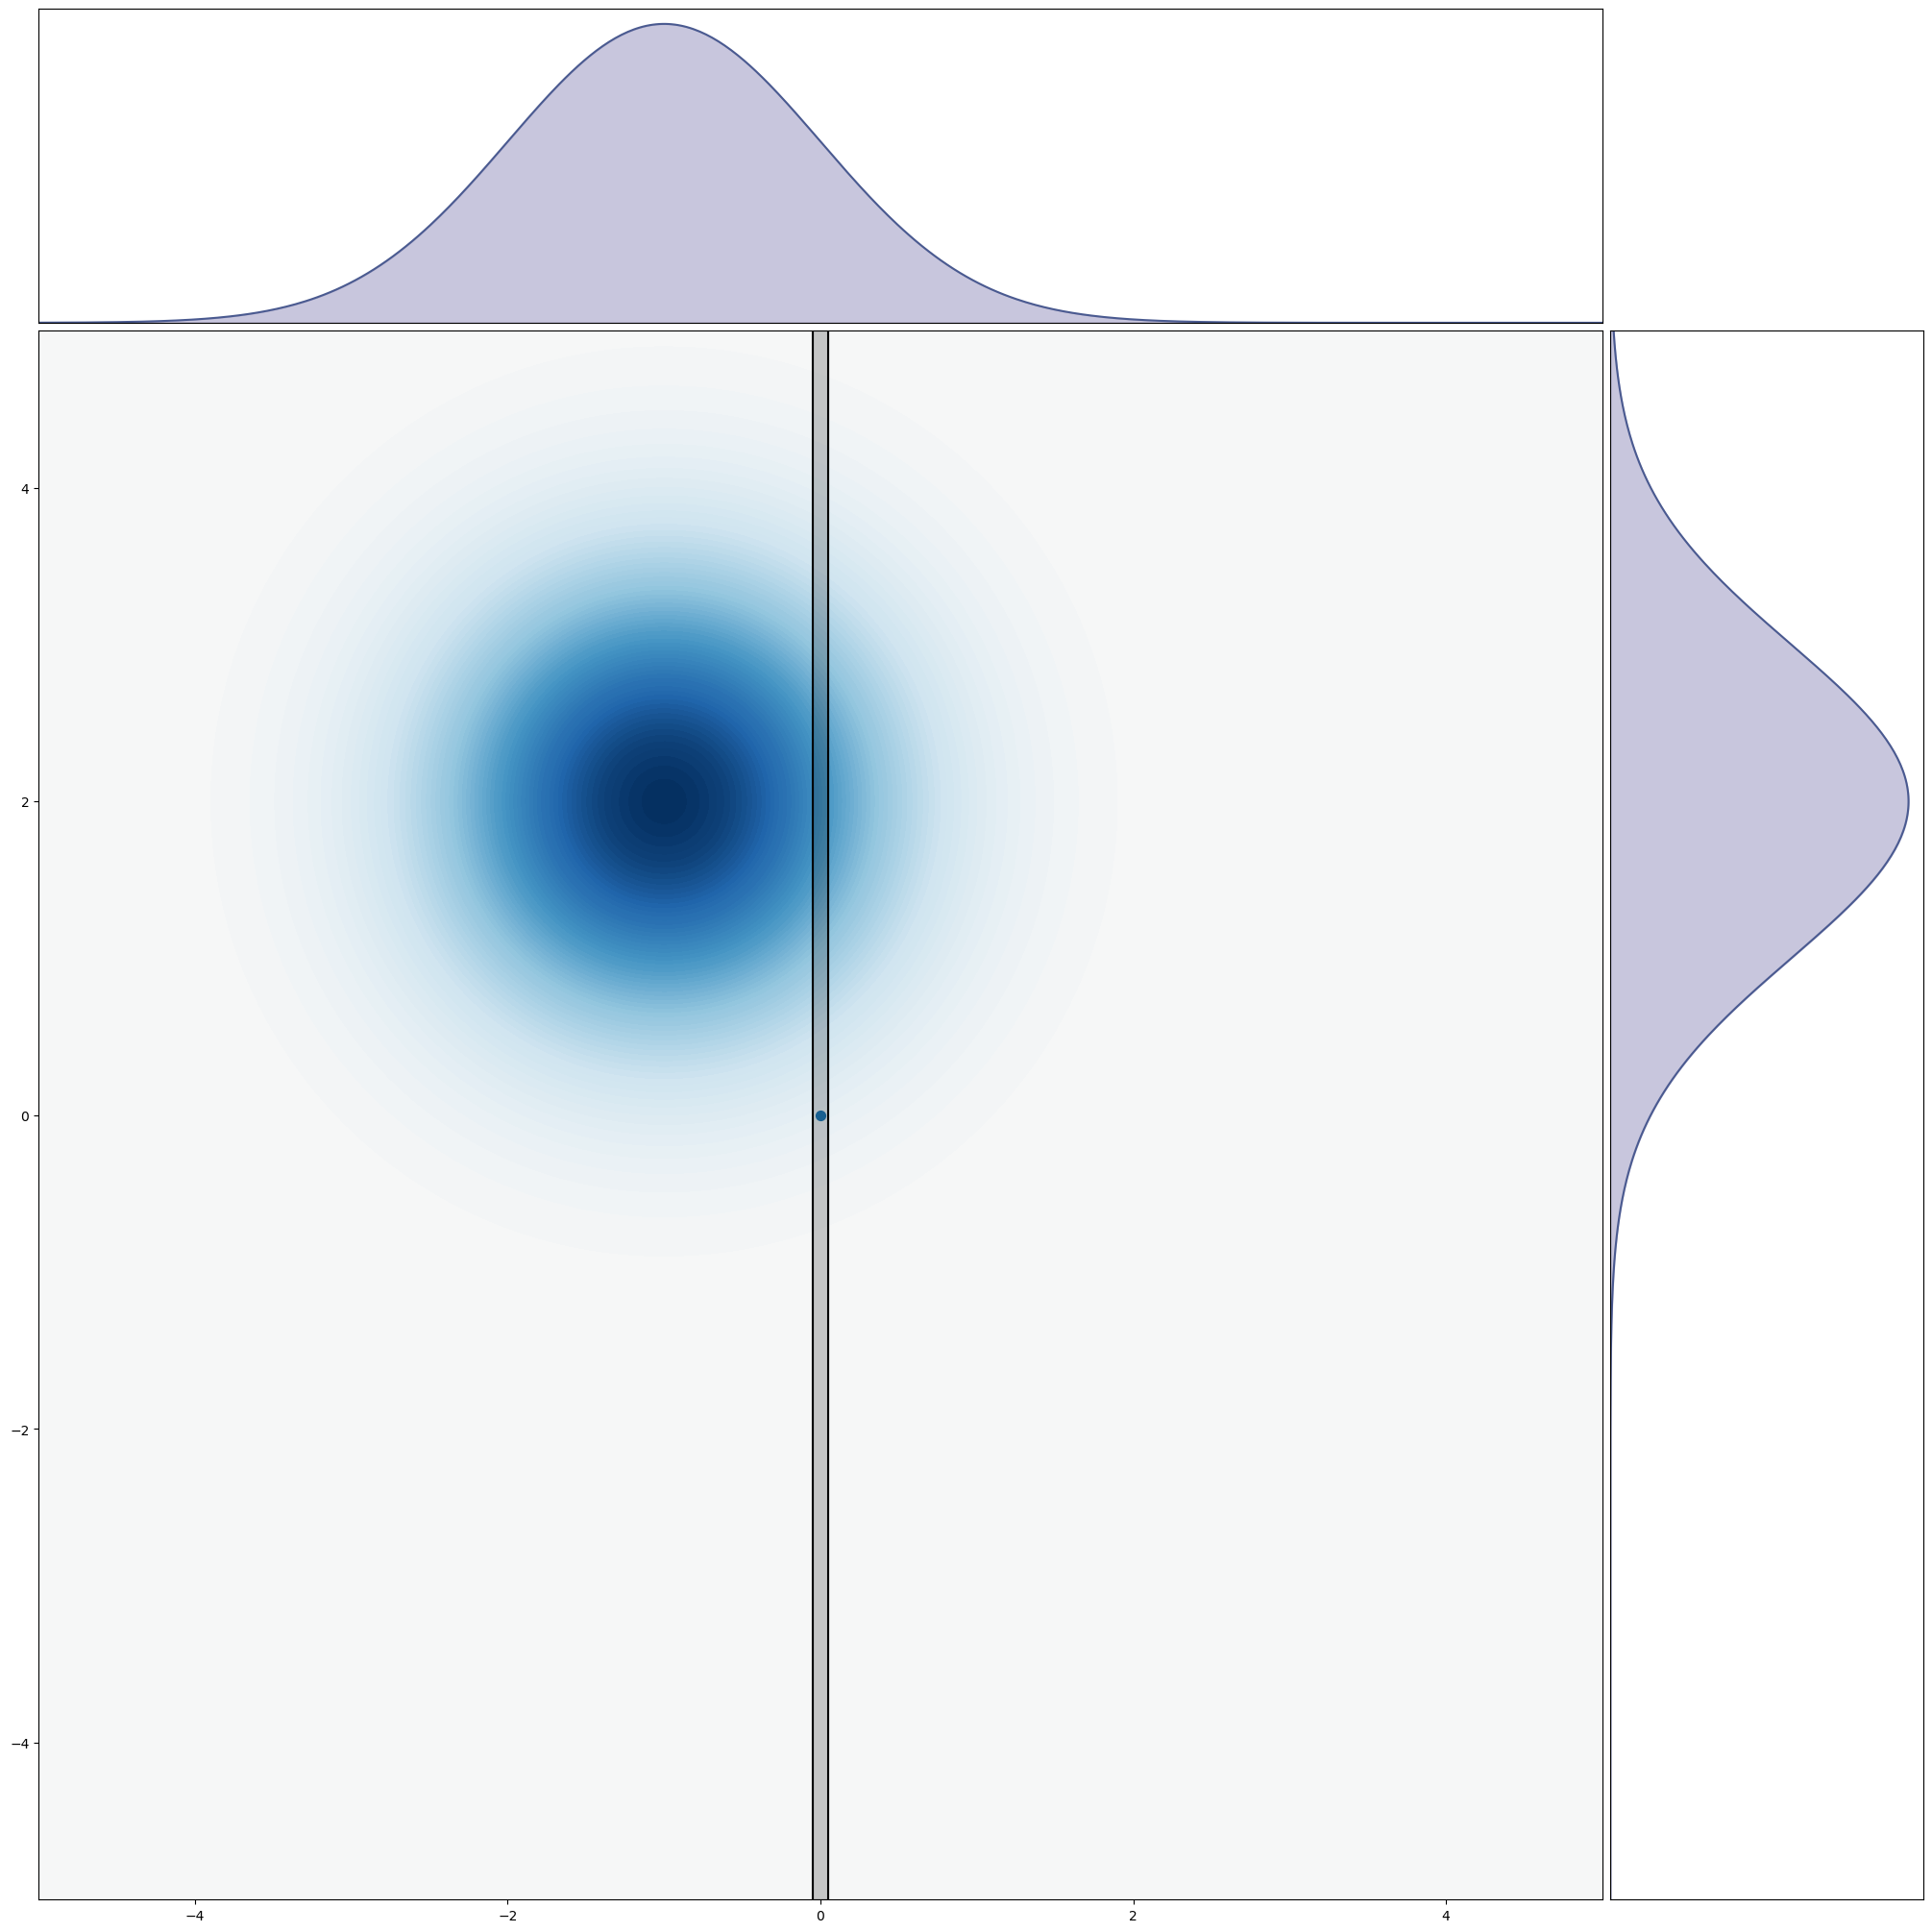

<Figure size 640x480 with 0 Axes>

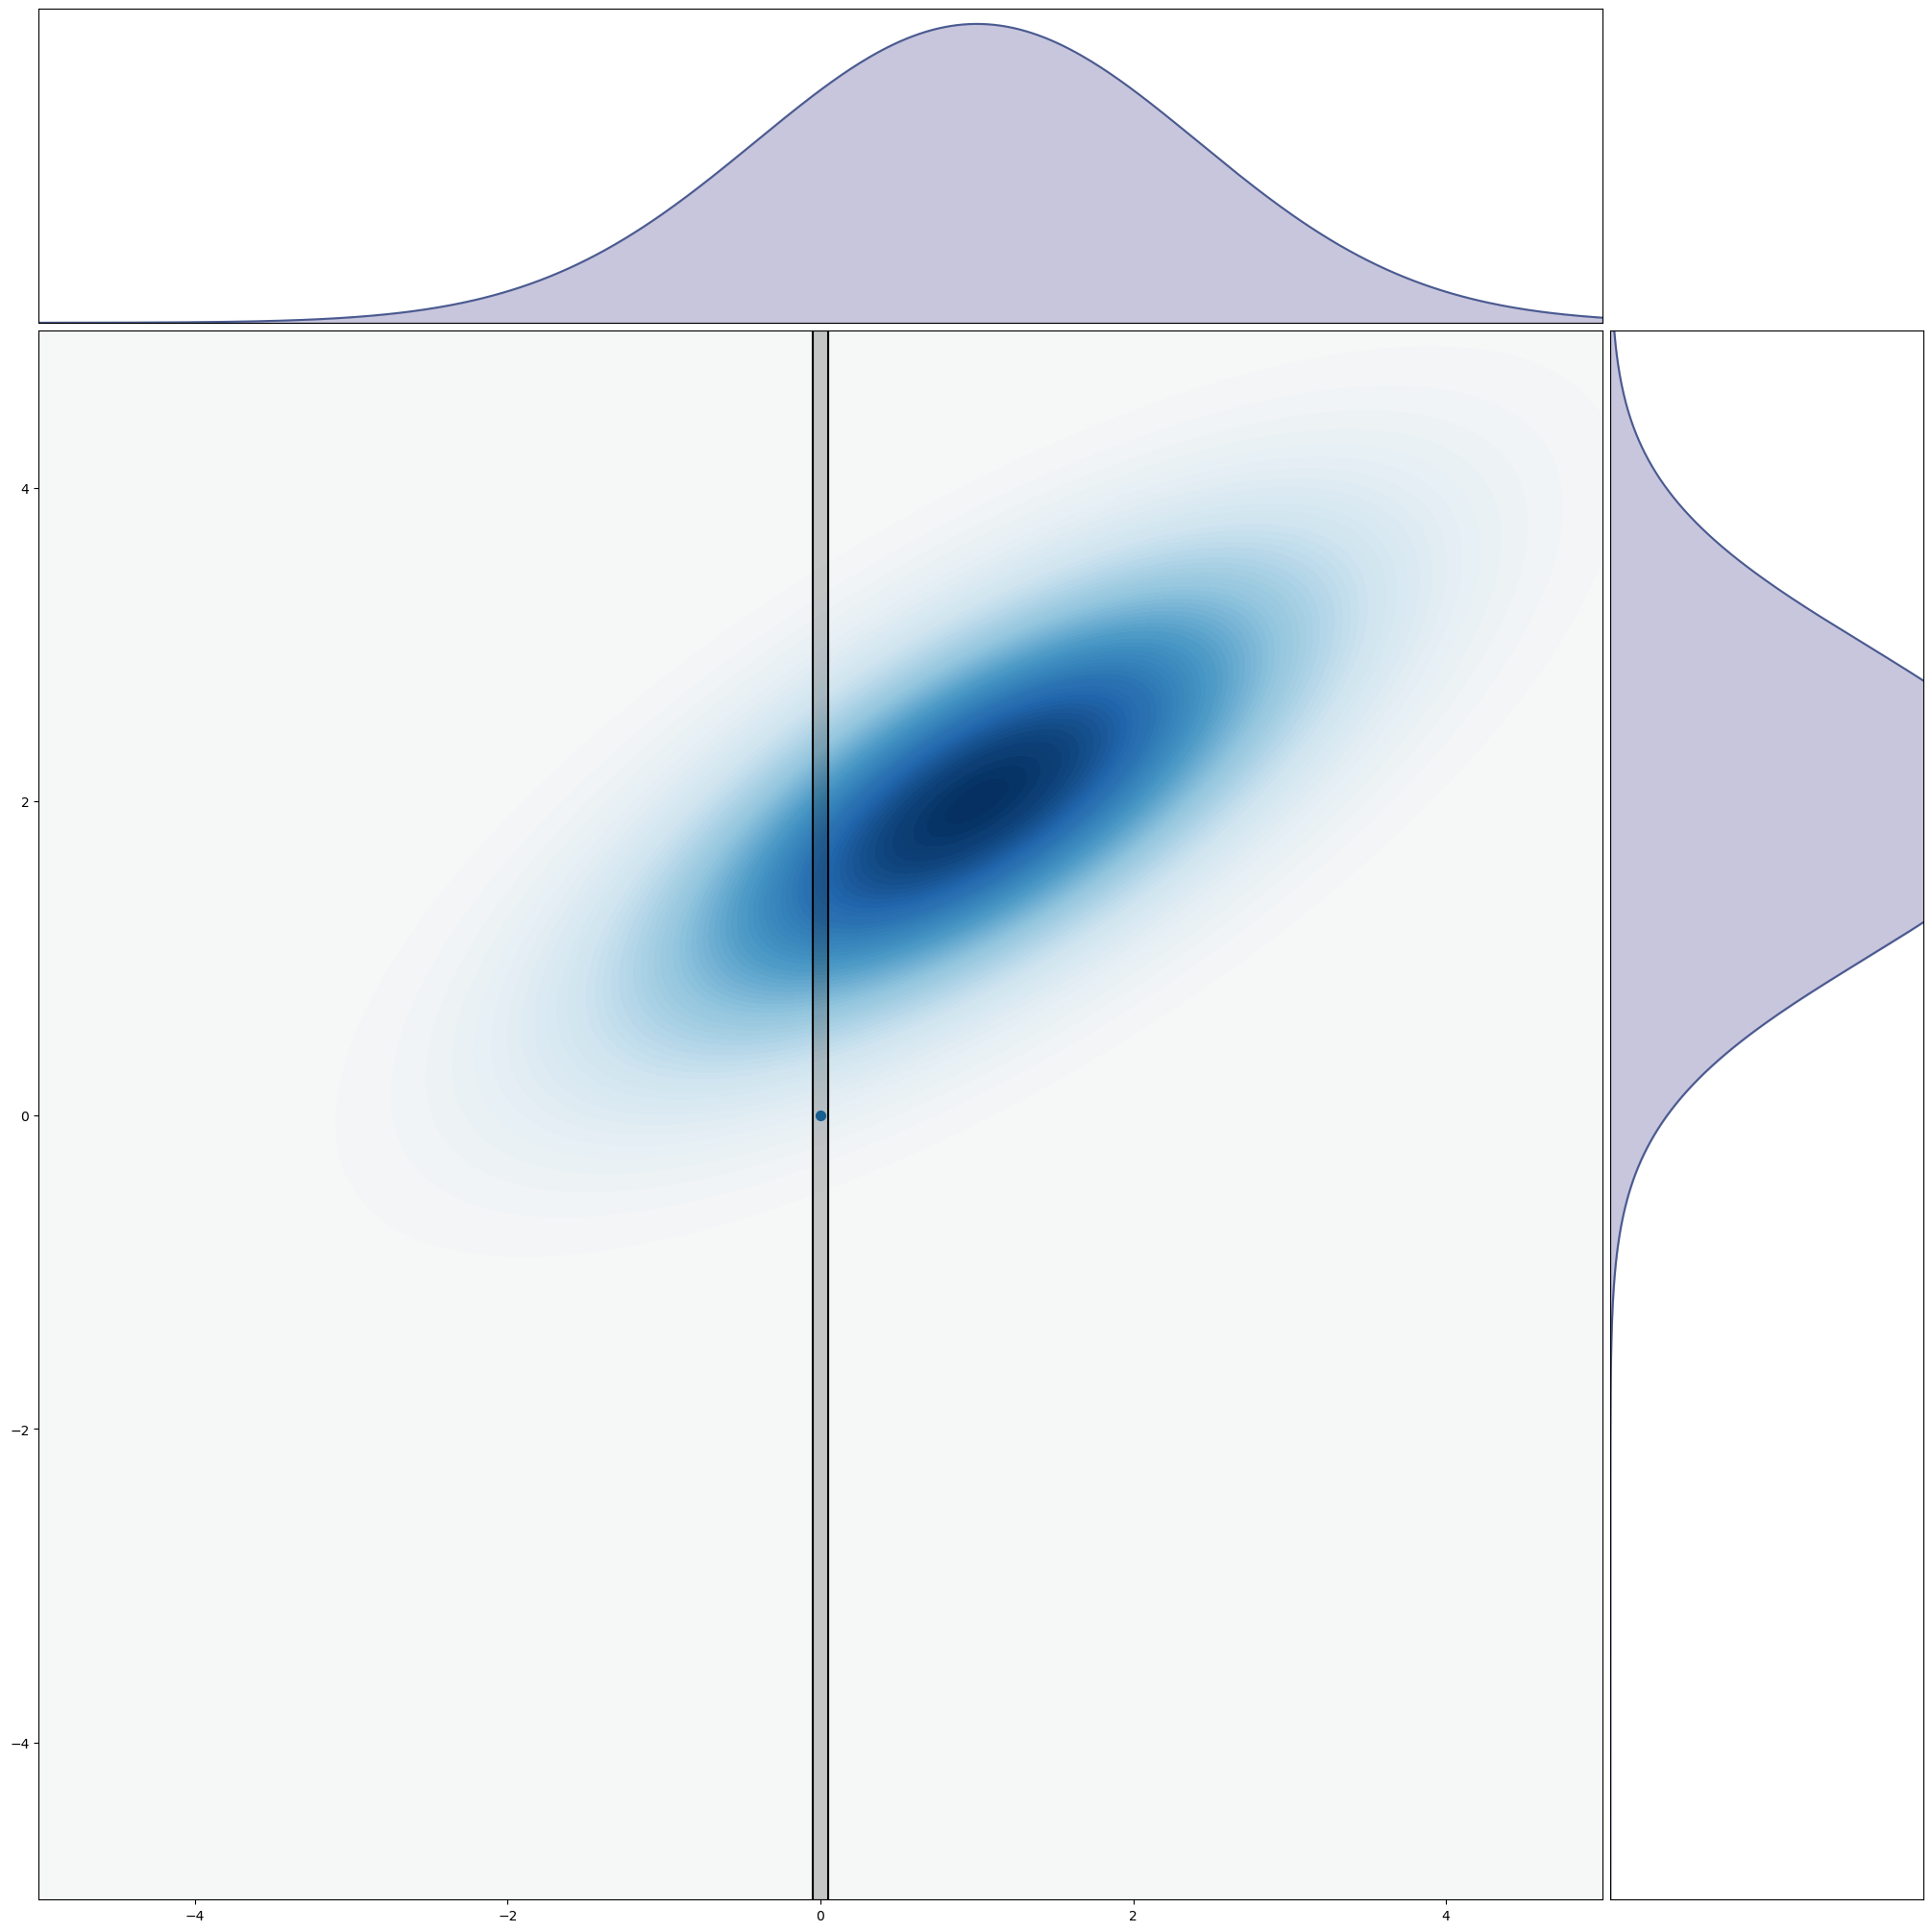

In [65]:
radius = 5
resolution = 500

xvec = np.linspace(-radius, radius, int(resolution))
yvec = np.linspace(-radius, radius, int(resolution))
x0, y0 = 2, -1
v0 = 1

for t in [-1, 0, 1]:
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    marginal_max = max(np.sum(W, axis=0))
    fig, axes = plot_wigner_marginals(W, xvec, yvec, marginal_max, resolution=200, angle=0)
    ax = axes["mid"]
    delta = 0.05
    ax.scatter(0, 0, s=50)
    ax.axvline(-delta, color="black")
    ax.axvline(delta, color="black")
    ax.fill_betweenx(yvec, -delta, delta, color="black", alpha=0.2)
    
    # display(fig)

In [112]:
for t in [-1, 0, 1]:
    W0 = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0) ** 2) / 2)
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    marginal_max = max(np.sum(W, axis=0))
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    norm = mpl.colors.Normalize(-wlim, wlim)
    ax = axes[0]
    ax.contourf(xvec, yvec, W, resolution // 3, norm=norm, cmap=cmap)
    # delta = 0.05
    # ax.scatter(0, 0, s=50)
    # ax.axvline(-delta, color="black")
    # ax.axvline(delta, color="black")
    # ax.fill_betweenx(yvec, -delta, delta, color="black", alpha=0.2)
    
    ax = axes[1]
    ax.contourf(xvec, yvec, W0, resolution // 3, norm=norm, cmap=cmap)
    y = np.linspace(-radius, radius, 3)
    x = - y * t * v0
    ax.scatter(0, 0, s=50)
    ax.plot(x - delta, y, color="black")
    ax.plot(x + delta, y, color="black")
    ax.set_xlim(-radius, radius)
    ax.fill_betweenx(y, x - delta, x + delta, color="black", alpha=0.2)

In [111]:
t_extremum = x0 / y0 / v0
times = [t_extremum - 5, t_extremum, 0, t_extremum + 10]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
titles = [fr"$t \to -\infty$", fr"$t = t_{{extremum}}$", fr"$t = 0$", fr"$t \to +\infty$"]
for i, t in enumerate(times):
    
    W0 = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0) ** 2) / 2)
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    marginal_max = max(np.sum(W, axis=0))
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']
    
    ax = axes[i // 2, i % 2]  # Select the appropriate subplot

    ax.contourf(xvec, yvec, W0, resolution // 3, norm=norm, cmap=cmap)
    delta = 0.05
    y = np.linspace(-radius, radius, 3)
    x = - y * t * v0
    ax.scatter(0, 0, s=50)
    ax.plot(x - delta, y, color="black")
    ax.plot(x + delta, y, color="black")
    ax.set_xlim(-radius, radius)
    ax.fill_betweenx(y, x - delta, x + delta, color="black", alpha=0.2)
    
    circle_radius = np.sqrt(x0**2 + y0**2)
    circle = plt.Circle((y0, x0), circle_radius, color='red', alpha=0.5, linestyle="dashed", fill=False)
    ax.add_artist(circle)
    
    ax.set_title(titles[i])

plt.show()
plt.savefig("negative_probability_flow.png")

/tmp/ipykernel_25243/3663054921.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [113]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

mpl.use('agg')

radius = 5
resolution = 500
dir_path = "./shear_wigner"

xvec = np.linspace(-radius, radius, int(resolution))
yvec = np.linspace(-radius, radius, int(resolution))
x0, y0 = 2, -1
v0 = 1

times = np.linspace(-2, 2, 48)
# times = times * np.abs(times) * 5


W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0) ** 2) / 2)
marginal_max = max(np.sum(W, axis=0))
y_marginal = np.sum(W, axis=1)

for N, t in tqdm(enumerate(times)):
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']
    
    fig = plt.figure()
    n, m = 5, 1
    fig, axes = plt.subplot_mosaic(
        [ ["top"] * n + ["3d"] * m ] * m + [ ["mid"] * n + ["right"] * m] * n,
    figsize=(20, 20),
    layout="constrained",
    width_ratios=[1.05] * (n+m))

    ax = axes["mid"]
    norm = mpl.colors.Normalize(-wlim, wlim)
    ax.contourf(xvec, yvec, W, resolution // 3, norm=norm, cmap=cmap)
    
    ax = axes["top"]
    x_marginal = np.sum(W, axis=0)
    ax.fill_between(xvec, x_marginal, 0, color='#938fbc', alpha=0.5)
    ax.plot(xvec, x_marginal, color='#4a5a90')
    ax.set_xlim(min(xvec), max(xvec))
    ax.set_ylim(0, marginal_max * 1.05)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes["right"]
    ax.fill_betweenx(yvec, y_marginal, 0, color='#938fbc', alpha=0.5)
    ax.plot(y_marginal, yvec, color='#4a5a90')
    ax.set_xlim(0, marginal_max * 1.05)
    ax.set_ylim(min(yvec), max(yvec))
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes["3d"]
    ax.axis('off')
    
    ax = axes["mid"]
    # delta = 0.05
    # ax.scatter(0, 0, s=50)
    # ax.axvline(-delta, color="black")
    # ax.axvline(delta, color="black")
    # ax.fill_betweenx(yvec, -delta, delta, color="black", alpha=0.2)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    fig.savefig(f"{dir_path}/{N:03d}.png", bbox_inches='tight')
    plt.close(fig)
    

48it [00:33,  1.44it/s]


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

mpl.use('agg')

radius = 5
resolution = 500
dir_path = "./shear_wigner"

xvec = np.linspace(-radius, radius, int(resolution))
yvec = np.linspace(-radius, radius, int(resolution))
x0, y0 = 2, -1
v0 = 1

times = np.linspace(-2, 2, 48)

W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0) ** 2) / 2)
marginal_max = max(np.sum(W, axis=0))
y_marginal = np.sum(W, axis=1)

fig = plt.figure(figsize=(20, 20))
plot_indices = [0, 15, 23, 44]
for N, t in tqdm(enumerate(times)):
    if N not in plot_indices:
        continue
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']
    
    n, m = 5, 1
    ax = plt.subplot(2, 2, plot_indices.index(N)+1)
    
    norm = mpl.colors.Normalize(-wlim, wlim)
    ax.contourf(xvec, yvec, W, resolution // 3, norm=norm, cmap=cmap)

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
fig.savefig(f"{dir_path}/shear_wigner_all.png", bbox_inches='tight')
plt.close(fig)

48it [00:01, 43.72it/s]


In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
a = 1.3
hbar = 1

# Create a grid of q and p values
q = np.linspace(-a/2, a/2, 1000)
p = np.linspace(-20, 20, 1000)
Q, P = np.meshgrid(q, p)

# Define the Wigner function
W = np.sin(P * (a - 2 * np.abs(Q)) / hbar) / (a * np.pi * P)

# Define the marginal distribution
p_marginal = np.linspace(-20, 20, 1000)  # Define p for marginal
marginal = hbar / (np.pi * a * p_marginal**2) * (1 - np.cos(p_marginal * a / hbar))

# Create the contour plot
fig, axes = plt.subplot_mosaic("AAAB", figsize=(10, 5))

cmap = plt.colormaps['RdBu']

cont = axes["A"].contourf(Q, P, W, 100)
axes["A"].set_xlabel('q')
axes["A"].set_ylabel('p')
axes["A"].set_title('Wigner Function')
fig.colorbar(cont, ax=axes["A"])

axes["B"].plot(marginal, p_marginal)
# remove ticks
axes["B"].set_yticks([])
axes["B"].set_title(r'$\rho_p$')

plt.tight_layout()
plt.savefig("square_wave_Wigner.png")

In [138]:
x0, y0, v0 = 0, 0, 1
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
titles = [fr"$t \to -\infty$", fr"$t = t_{{extremum}}$", fr"$t = 0$", fr"$t \to +\infty$"]
radius = 2
resolution = 500
dir_path = "./gaussian_wavepacket_spreading"

xvec = np.linspace(-radius, radius, int(resolution))
yvec = np.linspace(-radius, radius, int(resolution))

times = np.linspace(-2, 2, 49)
for N, t in enumerate(times):
    W0 = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0) ** 2) / 2)
    W = np.exp(-((xvec[:, np.newaxis] - x0) ** 2 + (yvec[np.newaxis, :] - y0 - xvec[:, np.newaxis] * v0 * t) ** 2) / 2)
    marginal_max = max(np.sum(W, axis=0))
    wmap = wigner_cmap(W)
    wlim = np.abs(W).max()
    cmap = plt.colormaps['RdBu']
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(xvec, yvec, W0, resolution // 3, norm=norm, cmap=cmap)
    y = np.linspace(-radius, radius, 3)
    x = - y * t * v0
    ax.scatter(0, 0, s=50)
    
    delta = 1 * np.sqrt(1 + t**2)
    ax.plot(x - delta, y, color="black")
    ax.plot(x + delta, y, color="black")
    ax.set_xlim(-radius, radius)
    ax.fill_betweenx(y, x - delta, x + delta, color="black", alpha=0.2)
    
    circle_radius = 1
    circle = plt.Circle((0, 0), circle_radius, color='red', alpha=0.5, linestyle="dashed", fill=False)
    ax.add_artist(circle)
    ax.axhline([0])
    
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    fig.savefig(f"{dir_path}/{N:03d}.png", bbox_inches='tight')
    plt.close()